<a href="https://colab.research.google.com/github/chasubeen/python_selfstudy/blob/master/deep_pytorch/5.%20%ED%95%98%EC%9D%B4%EB%B8%8C%EB%A6%AC%EB%93%9C%20%EA%B3%A0%EA%B8%89%20%EB%AA%A8%EB%8D%B8%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **언어 모델링을 위한 트랜스포머 모델 만들기**

## **파이토치에서 트랜스포머 모델 정의하기**

### **a) 모델 아키텍처 정의**

In [ ]:
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torchtext
from torchtext.data.utils import get_tokenizer

In [ ]:
class Transformer(nn.Module):

    ### 초기화 함수
    def __init__(self, num_token, num_inputs, num_heads, num_hidden, num_layers, dropout = 0.3):
        """
        num_token: 어휘 사전의 크기로, 임베딩 레이어의 출력 차원을 결정
        num_inputs: 임베딩 레이어의 입력 및 출력 차원으로, 모델 내부에서의 특성 차원을 결정
        num_heads: 멀티 헤드 어텐션에서 사용되는 어텐션 헤드의 개수
        num_hidden: 피드포워드 신경망의 은닉층 크기
        num_layers: Transformer의 총 레이어 수
        dropout: 드롭아웃 확률로, 모델에서 사용되는 드롭아웃의 정도를 결정
        """
        super(Transformer, self).__init__()
        self.model_name = 'transformer'
        self.mask_source = None

        ## Encoding
        # 위치 인코딩
        self.position_enc = PosEnc(num_inputs, dropout)
        # encoder layer 정의
        layers_enc = TransformerEncoderLayer(num_inputs, num_heads, num_hidden, dropout)
        # 여러 개의 인코더 레이어를 쌓아 인코더를 형성
        self.enc_transformer = TransformerEncoder(layers_enc, num_layers)
        # 입력 토큰을 임베딩 벡터로 변환
        self.enc = nn.Embedding(num_token, num_inputs)
        self.num_inputs = num_inputs

        ## 언어 모델링 작업의 경우 단어 시퀀스를 입력으로 받아 단일 출력만 내면 됨
        # 디코더: 인코더의 벡터 시퀀스를 단일 출력 벡터로 변환하는 선형 계층
        self.dec = nn.Linear(num_inputs, num_token)

        # 가중치와 bias를 초기화
        self.init_params()

    ### 다음 위치 이후의 위치에 대한 마스크를 생성하는 함수
    # 현재 위치 이후의 위치에 대한 정보를 가리기 위해 사용됨
    def _gen_sqr_nxt_mask(self, size):
        msk = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        msk = msk.float().masked_fill(msk == 0, float('-inf'))
        msk = msk.masked_fill(msk == 1, float(0.0))
        return msk

    def init_params(self):
        initial_rng = 0.12
        self.enc.weight.data.uniform_(-initial_rng, initial_rng)
        self.dec.bias.data.zero_()
        self.dec.weight.data.uniform_(-initial_rng, initial_rng)

    ### 모델의 순전파를 정의
    # 입력 데이터를 임베딩하고 위치 인코딩을 적용
    # 이후 Transformer의 인코더 레이어를 통과시키고 최종 출력을 예측값으로 변환
    def forward(self, source):
        if self.mask_source is None or self.mask_source.size(0) != len(source):
            dvc = source.device
            msk = self._gen_sqr_nxt_mask(len(source)).to(dvc)
            self.mask_source = msk

        ## 입력(encoding)
        source = self.enc(source) * math.sqrt(self.num_inputs)
        ## 위치 인코딩
        source = self.position_enc(source)
        op = self.enc_transformer(source, self.mask_source)
        ## 출력(decoding)
        op = self.dec(op)
        return op

In [ ]:
### 위치 인코딩

class PosEnc(nn.Module):
  def __init__(self, d_m, dropout=0.2, size_limit=5000):
    # d_m is same as the dimension of the embeddings
    super(PosEnc, self).__init__()
    self.dropout = nn.Dropout(dropout)
    p_enc = torch.zeros(size_limit, d_m)
    pos = torch.arange(0, size_limit, dtype=torch.float).unsqueeze(1)
    divider = torch.exp(torch.arange(0, d_m, 2).float() * (-math.log(10000.0) / d_m))
    # divider is the list of radians, multiplied by position indices of words, and fed to the sinusoidal and cosinusoidal function
    p_enc[:, 0::2] = torch.sin(pos * divider)
    p_enc[:, 1::2] = torch.cos(pos * divider)
    p_enc = p_enc.unsqueeze(0).transpose(0, 1)
    self.register_buffer('p_enc', p_enc)

  def forward(self, x):
    return self.dropout(x + self.p_enc[:x.size(0), :])

### **b) 데이터셋 로딩 및 처리**

**장치 및 데이터 준비**
- 위키피디아의 WikiText-2 사용
- 데이터셋 로딩 시의 버그가 발생함
  - url이 만료된 것 같음,,

In [ ]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"), lower=True, eos_token='<eos>', init_token='<sos>')
training_text, validation_text, testing_text = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(training_text)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**훈련/검증 set 정의**

In [ ]:
### 배치 생성 함수

def gen_batches(text_dataset, batch_size):
    text_dataset = TEXT.numericalize([text_dataset.examples[0].text])

    # 텍스트 데이터셋을 batch_size와 동일한 크기의 부분으로 나눔
    num_batches = text_dataset.size(0) // batch_size

    # 배치 밖에 위치한 데이터 포인트(나머지에 해당하는 부분)을 제거
    text_dataset = text_dataset.narrow(0, 0, num_batches * batch_size)

    # 데이터셋을 배치에 균등하게 배포
    text_dataset = text_dataset.view(batch_size, -1).t().contiguous()

    return text_dataset.to(device)

In [ ]:
# 배치 크기 정의
training_batch_size = 32
evaluation_batch_size = 16

training_data = gen_batches(training_text, training_batch_size)
validation_data = gen_batches(validation_text, evaluation_batch_size)
testing_data = gen_batches(testing_text, evaluation_batch_size)

**시퀀스 생성**
- 최대 시퀀스 길이를 정의하고 그에 따라 입력 시퀀스와 각 배치에 대한 출력 타깃을 생성

In [ ]:
max_seq_len = 64 # 최대 시퀀스 길이

def return_batch(src, k):
    sequence_length = min(max_seq_len, len(src) - 1 - k)
    sequence_data = src[k:k+sequence_length]
    sequence_label = src[k+1:k+1+sequence_length].view(-1)
    return sequence_data, sequence_label

### **c) 트랜스포머 모델 훈련**

**하이퍼 파라미터 정의**

In [ ]:
num_tokens = len(TEXT.vocab.stoi) # vocabulary size
embedding_size = 256 # dimension of embedding layer
num_hidden_params = 256 # transformer encoder's hidden (feed forward) layer dimension
num_layers = 2 # num of transformer encoder layers within transformer encoder
num_heads = 2 # num of heads in (multi head) attention models
dropout = 0.25 # value (fraction) of dropout
loss_func = nn.CrossEntropyLoss()
lrate = 4.0 # learning rate

**트랜스포머 모델 인스턴스화**

In [ ]:
transformer_model = Transformer(num_tokens, embedding_size, num_heads, num_hidden_params, num_layers,
                                     dropout).to(device)
optim_module = torch.optim.SGD(transformer_model.parameters(), lr=lrate)
sched_module = torch.optim.lr_scheduler.StepLR(optim_module, 1.0, gamma=0.88)

**훈련/평가 루틴 정의**

In [ ]:
### 훈련

def train_model():
    transformer_model.train()
    loss_total = 0.
    time_start = time.time()
    num_tokens = len(TEXT.vocab.stoi)
    for b, i in enumerate(range(0, training_data.size(0) - 1, max_seq_len)):
        train_data_batch, train_label_batch = return_batch(training_data, i)
        optim_module.zero_grad()
        op = transformer_model(train_data_batch)
        loss_curr = loss_func(op.view(-1, num_tokens), train_label_batch)
        loss_curr.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), 0.6)
        optim_module.step()

        loss_total += loss_curr.item()
        interval = 100
        if b % interval == 0 and b > 0:
            loss_interval = loss_total / interval
            time_delta = time.time() - time_start
            print(f"epoch {ep}, {b}/{len(training_data)//max_seq_len} batches, training loss {loss_interval:.2f}, training perplexity {math.exp(loss_interval):.2f}")
            loss_total = 0
            time_start = time.time()

In [ ]:
### 평가

def eval_model(eval_model_obj, eval_data_source):
    eval_model_obj.eval()
    loss_total = 0.
    num_tokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for j in range(0, eval_data_source.size(0) - 1, max_seq_len):
            eval_data, eval_label = return_batch(eval_data_source, j)
            op = eval_model_obj(eval_data)
            op_flat = op.view(-1, num_tokens)
            loss_total += len(eval_data) * loss_func(op_flat, eval_label).item()
    return loss_total / (len(eval_data_source) - 1)

**Run!!**

In [ ]:
min_validation_loss = float("inf")
eps = 5
best_model_so_far = None

for ep in range(1, eps + 1):
    ep_time_start = time.time()
    train_model()
    validation_loss = eval_model(transformer_model, validation_data)
    print()
    print(f"epoch {ep:}, validation loss {validation_loss:.2f}, validation perplexity {math.exp(validation_loss):.2f}")
    print()

    if validation_loss < min_validation_loss:
        min_validation_loss = validation_loss
        best_model_so_far = transformer_model

    sched_module.step()

epoch 1, 100/1018 batches, training loss 8.50, training perplexity 4901.66
epoch 1, 200/1018 batches, training loss 7.16, training perplexity 1286.24
epoch 1, 300/1018 batches, training loss 6.76, training perplexity 865.43
epoch 1, 400/1018 batches, training loss 6.55, training perplexity 702.21
epoch 1, 500/1018 batches, training loss 6.45, training perplexity 631.90
epoch 1, 600/1018 batches, training loss 6.31, training perplexity 548.01
epoch 1, 700/1018 batches, training loss 6.25, training perplexity 516.28
epoch 1, 800/1018 batches, training loss 6.11, training perplexity 450.42
epoch 1, 900/1018 batches, training loss 6.09, training perplexity 441.72
epoch 1, 1000/1018 batches, training loss 6.08, training perplexity 436.78

epoch 1, validation loss 5.82, validation perplexity 336.19

epoch 2, 100/1018 batches, training loss 5.98, training perplexity 394.64
epoch 2, 200/1018 batches, training loss 5.90, training perplexity 364.08
epoch 2, 300/1018 batches, training loss 5.82, 

- 교차 엔트로피 손실 외에 혼란도(preplexity)도 같이 확인 가능


### **d) 평가**

In [ ]:
testing_loss = eval_model(best_model_so_far, testing_data)
print(f"testing loss {testing_loss:.2f}, testing perplexity {math.exp(testing_loss):.2f}")

testing loss 5.14, testing perplexity 171.47


# **RandWireNN 모델 구현**

## **RandWireNN 개발**
- 이미지 분류 작업을 위한 RandWireNN 모델 개발
  - CIFAR-10 데이터셋에서 수행됨
- 빈 모델로 시작해 랜덤 그래프를 생성하고 해당 그래프를 신경망으로 변환한 다음 주어진 데이터셋에서 주어진 작업에 맞게 훈련시킨 뒤 훈련된 모델을 평가
- 마지막으로 생성된 결과 모델을 탐색

### **a) 훈련 루틴 정의 및 데이터 로딩**
- 모델 훈련 루프에서 호출한 훈련 함수를 정의
- 훈련에 필요한 데이터 배치를 제공할 데이터셋 로더를 정의

In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=352bd887f6f8cf40cc9470d3758dfdf0c4a7261e308b022a93616bfbd8f0527d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torchvision import datasets, transforms
from torchviz import make_dot

import os
import time
import random
import networkx as nx
import yaml
import matplotlib.pyplot as plt

In [4]:
# 장치 설정

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

**helper 함수**
- 시각화를 위한 함수 정의

In [5]:
def plot_results(list_of_epochs, list_of_train_losses, list_of_train_accuracies, list_of_val_accuracies):
    plt.figure(figsize = (20, 9))
    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_train_losses, label = 'training loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_train_accuracies, label = 'training accuracy')
    plt.plot(list_of_epochs, list_of_val_accuracies, label = 'validation accuracy')
    plt.legend()

    if not os.path.isdir('./result_plots'):
        os.makedirs('./result_plots')
    plt.savefig('./result_plots/accuracy_plot_per_epoch.jpg')
    plt.close()

**훈련 루틴 정의**
- RGB 입력 이미지가 주어지면 예측 확률을 만들 수 있는 훈련된 모델을 취함

In [6]:
### 학습률 설정

def set_lr(optim, epoch_num, lrate):
  """adjusts lr to starting lr thereafter reduced by 10% at every 20 epochs"""
  lrate = lrate * (0.1 ** (epoch_num // 20))
  for params in optim.param_groups:
    params['lr'] = lrate

In [7]:
def train(model, train_dataloader, optim, loss_func, epoch_num, lrate):

  model.train() # 훈련 모드

  loop_iter = 0
  training_loss = 0
  training_accuracy = 0

  for training_data, training_label in train_dataloader:

    set_lr(optim, epoch_num, lrate) # learning rate 설정

    training_data, training_label =\
      training_data.to(device), training_label.to(device)

    optim.zero_grad()

    pred_raw = model(training_data)

    curr_loss = loss_func(pred_raw, training_label)
    curr_loss.backward()
    optim.step()
    training_loss += curr_loss.data
    pred = pred_raw.data.max(1)[1]

    curr_accuracy =\
        float(pred.eq(training_label.data).sum()) * 100. / len(training_data)
    training_accuracy += curr_accuracy
    loop_iter += 1

    if loop_iter % 100 == 0:
      print(f"epoch {epoch_num}, loss: {curr_loss.data}, accuracy: {curr_accuracy}")

  data_size = len(train_dataloader.dataset) // batch_size

  return training_loss / data_size, training_accuracy / data_size

**평가 metric 정의**
- 정확도로 설정

In [8]:
def accuracy(model, test_data_loader):

  model.eval() # 평가 모드

  success = 0

  with torch.no_grad():
    for test_data, test_label in test_data_loader:
      test_data, test_label = test_data.to(device), test_label.to(device)
      pred_raw = model(test_data)
      pred = pred_raw.data.max(1)[1]
      success += pred.eq(test_label.data).sum()

  return float(success) * 100. / len(test_data_loader.dataset)

**데이터로더 정의**
- CIFAR-10 데이터셋을 활용
  - 10개의 클래스와 클래스 당 6천개 => 총 6만개의 32 x 32 RGB 이미지로 구성된 데이터베이스
- ```torchvision.datasets```를 통해 로딩

In [9]:
batch_size = 64

In [10]:
def load_dataset(batch_size):
  # 데이터셋 로드
  transform_train_dataset = transforms.Compose([
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
  ])
  transform_test_dataset = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
  ])

  # 데이터로더 정의
  train_dataloader = torch.utils.data.DataLoader(
      datasets.CIFAR10('dataset', transform = transform_train_dataset,
                        train = True, download = True),
      batch_size = batch_size,
      shuffle = True
  )
  test_dataloader = torch.utils.data.DataLoader(
      datasets.CIFAR10('dataset', transform = transform_test_dataset,
                        train = False),
      batch_size = batch_size,
      shuffle = False
  )

  return train_dataloader, test_dataloader

In [11]:
train_dataloader, test_dataloader = load_dataset(batch_size)

100%|██████████| 170498071/170498071 [00:03<00:00, 47025633.80it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset


### **b) 무작위로 연결된 그래프 정의**
- 신경망 모델 설계

**랜덤 그래프 생성 클래스 정의**

In [12]:
class RndGraph(object):
    ### 클래스 초기화
    def __init__(self, num_nodes, graph_probability, nearest_neighbour_k = 4, num_edges_attach = 5):
        self.num_nodes = num_nodes # 그래프의 노드 수
        self.graph_probability = graph_probability # 그래프에서 각 에지를 재배치할 확률
        self.nearest_neighbour_k = nearest_neighbour_k # 각 노드에 연결된 최근접 이웃 수
        self.num_edges_attach = num_edges_attach # 각 노드에 새로 연결할 에지 수

    ### 그래프 생성
    ## WS 그래프 모델을 인스턴스화
    def make_graph_obj(self):
        # 유명한 랜덤 그래프 모델인 와츠-스트로가츠 모델을 활용
        graph_obj = nx.random_graphs.connected_watts_strogatz_graph(self.num_nodes, self.nearest_neighbour_k, self.graph_probability)
        return graph_obj

    ### 그래프 구성 가져오기
    ## 그래프의 노드와 에지 목록을 반환
    ## 추상적인 그래프를 신경망으로 변환할 때 도움
    def get_graph_config(self, graph_obj):
        ## 노드 및 에지 정보 초기화
        incoming_edges = {} # 각 노드에 들어오는 에지의 목록
        incoming_edges[0] = []
        node_list = [0] # 그래프의 노드 목록
        last = []

        ## 노드 순회
        # 그래프 내의 노드를 하나씩 순회하며
        # 각 노드에 대해 인접한 이웃 노드의 목록을 가져옴
        for n in graph_obj.nodes():
            neighbor_list = list(graph_obj.neighbors(n))
            neighbor_list.sort()

            ## 에지 정보 추출
            edge_list = []
            passed_list = [] # 현재 노드보다 작은 이웃 노드들의 리스트
            for nbr in neighbor_list:
                # 각 이웃 노드에 대해 현재 노드보다 작은 값인 경우에만 에지 정보를 추출
                if n > nbr:
                    edge_list.append(nbr + 1) # 추출된 에지 정보 추가
                    passed_list.append(nbr)

            ## 에지 정보 저장
            # edge_list가 비어있다면 현재 노드와 연결된 에지가 없는 경우이므로 0을 추가
            if not edge_list:
                edge_list.append(0)
            incoming_edges[n + 1] = edge_list

            ## 마지막 노드 처리
            # passed_list가 이웃 노드 리스트와 같다면 현재 노드가 가장 큰 노드
            # 즉, 들어오는 에지가 없는 경우 => 마지막 노드
            if passed_list == neighbor_list:
                last.append(n + 1)

            # 노드 목록에 현재 노드를 추가
            node_list.append(n + 1)

        ## 마지막 노드 처리/반환
        # 모든 노드를 순회한 후에 마지막 노드에 대한 처리를 수행
        incoming_edges[self.num_nodes + 1] = last
        node_list.append(self.num_nodes + 1)

        # 최종적으로 노드의 목록과 입력된 에지를 반환
        return node_list, incoming_edges

    ### 생성된 그래프를 저장
    def save_graph(self, graph_obj, path_to_write):
        if not os.path.isdir("cached_graph_obj"):
            os.mkdir("cached_graph_obj")
        #nx.write_yaml(graph_obj, "./cached_graph_obj/" + path_to_write)
        with open("./cached_graph_obj/" + path_to_write, 'w') as fh:
            yaml.dump(graph_obj, fh)

    ### 이전에 생성된 그래프 불러오기
    def load_graph(self, path_to_read):
        #return nx.read_yaml("./cached_graph_obj/" + path_to_read)
        with open("./cached_graph_obj/" + path_to_read, 'r') as fh:
            return yaml.load(fh, Loader=yaml.Loader)

### **c) RnadWireNN 모델 모듈 정의**
- 위에서 정의한 랜덤 그래프 생성 모듈을 활용하여 해당 랜덤 그래프를 신경망으로 변환해야 함


**가중치 초기화를 위한 함수**

In [13]:
def initialize_weights(layer):
  if isinstance(layer, nn.Conv2d):
    torch.nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
      torch.nn.init.zeros_(layer.bias)

**분리 가능한 2차원 합성곱 계층 정의**
- 분리 가능한 합성곱 계층은 일반적인 3x3 2차원 합성곱 계층과 다음에 점별 1x1 2차원 합성곱 계층을 직렬로 연결한 것임

In [14]:
class SepConv2d(nn.Module):
  def __init__(self, input_ch, output_ch, kernel_length = 3,
               dilation_size = 1, padding_size = 1,
               stride_length = 1, bias_flag = True):
      super(SepConv2d, self).__init__()
      self.conv_layer = nn.Conv2d(input_ch, input_ch, kernel_length,
                                  stride_length, padding_size, dilation_size,
                                  bias = bias_flag, groups = input_ch)
      self.pointwise_layer = nn.Conv2d(input_ch, output_ch, kernel_size = 1,
                                        stride = 1, padding = 0, dilation = 1,
                                        groups = 1, bias = bias_flag)

  def forward(self, x):
    return self.pointwise_layer(self.conv_layer(x))

**ReLU-Conv-BN 삼중항 유닛 정의**
- 삼중항 유닛: ReLU - 분리 가능한 2차원 합성곱 계층 - 배치 정규화 계층을 순서대로 직렬로 연결한 것
- 여기에 정착화를 위한 드롭아웃 계층을 추가

In [15]:
class UnitLayer(nn.Module):
  def __init__(self, input_ch, output_ch, stride_length = 1):
    super(UnitLayer, self).__init__()

    self.dropout = 0.3

    self.unit_layer = nn.Sequential(
        nn.ReLU(),
        SepConv2d(input_ch, output_ch, stride_length=stride_length),
        nn.BatchNorm2d(output_ch),
        nn.Dropout(self.dropout)
    )

  def forward(self, x):
    return self.unit_layer(x)

**노드 정의**  

1. **Aggregation**
 - 하나의 노드(or 뉴런)로 들어오는 여러 에지의 가중합(weighted sum)을 구함
 - 해당 가중치는 학습 가능함

 2. **Transformation**
 - 그래프의 각 노드 내부에 표준 연산이 적용됨
 - ReLU, 3 x 3 분리 가능한(일반적으로 3 x 3 합성곱 다음에 1 x 1 점별 합성곱이 뒤따르는) 합성곱
 - 정규화가 순서대로 적용됨

 3. **Distribution**  
 - 각 뉴런에서 밖으로 나가는 여러 에지가 앞서 언급한 삼중항 연산의 복사본을 전달함

In [16]:
class GraphNode(nn.Module):
    def __init__(self, input_degree, input_ch, output_ch, stride_length=1):
        super(GraphNode, self).__init__()
        self.input_degree = input_degree

        if len(self.input_degree) > 1:
            self.params = nn.Parameter(torch.ones(len(self.input_degree), requires_grad=True))
        self.unit_layer = UnitLayer(
            input_ch, output_ch, stride_length=stride_length)

    def forward(self, *ip):
        ## 노드에 들어오는 에지 개수가 1보다 크다면
        # 가중 평균이 계산됨
        # 해당 가중치는 노드의 학습 가능한 매개변수임
        if len(self.input_degree) > 1:
            op = (ip[0] * torch.sigmoid(self.params[0]))
            for idx in range(1, len(ip)):
                op += (ip[idx] * torch.sigmoid(self.params[idx]))
            return self.unit_layer(op)
        else:
            return self.unit_layer(ip[0])

**그래프 & 그래프 노드 정의 통합**
- 무작위로 연결된 그래프 클래스를 정의
- 그래프와 그래프 노드 정의를 다음과 같이 모두 통합

In [17]:
class RandWireGraph(nn.Module):
    ### 랜덤 그래프 생성
    ## 그래프의 노드와 에지 리스트가 만들어짐
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode, graph_name):
        super(RandWireGraph, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.graph_name = graph_name

        # 그래프 노드와 유입(INCOMING) 에지 가져오기
        rnd_graph_node = RndGraph(self.num_nodes, self.graph_prob)
        if self.train_mode is True:
            print("train_mode: ON")
            rnd_graph = rnd_graph_node.make_graph_obj()
            self.node_list, self.incoming_edge_list =\
                rnd_graph_node.get_graph_config(rnd_graph)
            rnd_graph_node.save_graph(rnd_graph, graph_name)
        else:
            rnd_graph = rnd_graph_node.load_graph(graph_name)
            self.node_list, self.incoming_edge_list =\
                rnd_graph_node.get_graph_config(rnd_graph)

        ## 노드 정의
        # GraphNode 클래스를 사용해 해당 랜덤 그래프의 각 노드는 원하는 신경망의 뉴런으로 캡슐화 됨
        # 입력 노드 정의
        self.list_of_modules = nn.ModuleList(
            [GraphNode(self.incoming_edge_list[0],
                       self.input_ch,
                       self.output_ch,
                       stride_length = 2)])
        # 소스/입력 노드와 싱크/출력 노드가 네트워크에 추가됨 -> 이미지 분류 작업 수행
        self.list_of_modules.extend(
            [GraphNode(self.incoming_edge_list[n], self.output_ch,
                       self.output_ch) for n in self.node_list if n > 0])

    ### 순전파 메서드

    def forward(self, x):

        mem_dict = {}

        ## 시작점(소스 뉴런)
        # 해당 그래프의 list_of_nodes를 기반으로 후속 뉴런에 순전파가 순차적으로 실행됨
        op = self.list_of_modules[0].forward(x)
        mem_dict[0] = op

        # 나머지 꼭짓점
        for n in range(1, len(self.node_list) - 1):
            # print(node, self.in_edges[node][0], self.in_edges[node])
            if len(self.incoming_edge_list[n]) > 1:
                # 각 전파 실행
                op = self.list_of_modules[n].forward(
                    *[mem_dict[incoming_vtx]
                      for incoming_vtx in self.incoming_edge_list[n]])
            else:
                op = self.list_of_modules[n].forward(mem_dict[self.incoming_edge_list[n][0]])
            mem_dict[n] = op

        op = mem_dict[self.incoming_edge_list[self.num_nodes + 1][0]]

        # 마지막으로 순전파가 싱크 뉴런을 통과
        for incoming_vtx in range(1, len(self.incoming_edge_list[self.num_nodes + 1])):
            op += mem_dict[self.incoming_edge_list[self.num_nodes + 1][incoming_vtx]]

        # 그래프 출력
        return op / len(self.incoming_edge_list[self.num_nodes + 1])

### **d) 랜덤 그래프를 신경망으로 변환**
- 무작위로 연결된 신경망은 무작위로 연결된 그래프 여러 개가 단계적으로 이어져 구성됨
  - 이미지 분류 작업에서 입력 뉴런에서 출력 뉴런으로 진행하면서 다른(증가하는) 채널/특징 개수를 갖기 때문임
- 설계상 하나의 그래프를 통해서는 채널 수가 일정함 -> 단 하나의 무작위로 연결된 그래프는 존재할 수 없음

**무작위로 연결된 신경망**
- 서로 옆에 계단식으로 연결된 3개의 무작위로 연결된 그래프를 갖게 됨
- 각 그래프는 이미지 분류 작업에서(공간적으로 다운샘플링하는 동안) 채널 개수를 늘리는 일반적인 관행에 맞추는 데 도움이 되도록 이전 그래프에 비해 채널 개수를 2배로 늘림

In [18]:
class RandWireNNModel(nn.Module):
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode):
        super(RandWireNNModel, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.dropout = 0.3
        self.class_num = 10

        ## 일반적인 3x3 합성곱 계층으로 시작
        # 이후 숫자가 두 배로 늘어나는 채널이 있는 세 단계의 무작위로 연결된 그래프가 이어짐
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.output_ch,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(self.output_ch),
        )

        self.conv_layer_2 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch,
                          self.output_ch * 2, self.train_mode,
                          graph_name="conv_layer_2")
        )
        self.conv_layer_3 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*2,
                          self.output_ch*4, self.train_mode,
                          graph_name="conv_layer_3")
        )
        self.conv_layer_4 = nn.Sequential(
            RandWireGraph(self.num_nodes, self.graph_prob, self.input_ch*4,
                          self.output_ch*8, self.train_mode,
                          graph_name="conv_layer_4")
        )

        ## FC Layer
        # 나온 합성곱 출력을 크기가 1280인 벡터로 평면화
        self.classifier_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.input_ch*8, out_channels=1280,
                      kernel_size=1),
            nn.BatchNorm2d(1280)
        )

        ## 출력층
        # 10개 클래스에 대한 확률을 포함하는 크기가 10인 벡터 생성
        self.output_layer = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(1280, self.class_num)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.classifier_layer(x)

        # global average pooling
        _, _, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size = [h, w])
        x = torch.squeeze(x) # 1차원으로 펼치기
        x = self.output_layer(x)

        return x

### **e) RandWireNN 모델 훈련**

**하이퍼 파라미터 설정**

In [19]:
num_epochs = 5
graph_probability = 0.7
node_channel_count = 64
num_nodes = 16
lrate = 0.1
train_mode = True

**모델 객체 생성 & 옵티마이져, 손실함수 정의**

In [20]:
rand_wire_model = RandWireNNModel(num_nodes, graph_probability,
                                  node_channel_count, node_channel_count, train_mode).to(device)

optim_module = optim.SGD(rand_wire_model.parameters(), lr = lrate,
                         weight_decay = 1e-4, momentum = 0.8)
loss_func = nn.CrossEntropyLoss().to(device)

train_mode: ON
train_mode: ON
train_mode: ON


**Run!!**

In [21]:
epochs = []
test_accuracies = []
training_accuracies = []
training_losses = []
best_test_accuracy = 0

In [22]:
start_time = time.time()

for ep in range(1, num_epochs + 1):
    epochs.append(ep)
    training_loss, training_accuracy = train(rand_wire_model, train_dataloader,
                                             optim_module, loss_func, ep, lrate)
    test_accuracy = accuracy(rand_wire_model, test_dataloader)
    test_accuracies.append(test_accuracy)
    training_losses.append(training_loss.cpu())
    training_accuracies.append(training_accuracy)
    print('test acc: {0:.2f}%, best test acc: {1:.2f}%'.format(test_accuracy, best_test_accuracy))

    if best_test_accuracy < test_accuracy:
        model_state = {
            'model': rand_wire_model.state_dict(),
            'accuracy': test_accuracy,
            'ep': ep,
        }
        if not os.path.isdir('model_checkpoint'):
            os.mkdir('model_checkpoint')
        model_filename = "ch_count_" + str(node_channel_count) + "_prob_" +\
                          str(graph_probability)
        torch.save(model_state, './model_checkpoint/' + model_filename + 'ckpt.t7')
        best_test_accuracy = test_accuracy
        plot_results(epochs, training_losses, training_accuracies, test_accuracies)
    print("model train time: ", time.time() - start_time)

epoch 1, loss: 2.1268396377563477, accuracy: 17.1875
epoch 1, loss: 1.904039740562439, accuracy: 25.0
epoch 1, loss: 1.8447479009628296, accuracy: 20.3125
epoch 1, loss: 1.7813600301742554, accuracy: 39.0625
epoch 1, loss: 1.590218424797058, accuracy: 42.1875
epoch 1, loss: 1.4417997598648071, accuracy: 37.5
epoch 1, loss: 1.5898680686950684, accuracy: 42.1875
test acc: 48.48%, best test acc: 0.00%
model train time:  106.01585936546326
epoch 2, loss: 1.2612580060958862, accuracy: 50.0
epoch 2, loss: 1.4475202560424805, accuracy: 45.3125
epoch 2, loss: 1.1124799251556396, accuracy: 64.0625
epoch 2, loss: 1.4045560359954834, accuracy: 50.0
epoch 2, loss: 1.5506560802459717, accuracy: 46.875
epoch 2, loss: 1.4330064058303833, accuracy: 42.1875
epoch 2, loss: 1.1787127256393433, accuracy: 56.25
test acc: 49.81%, best test acc: 48.48%
model train time:  212.95551538467407
epoch 3, loss: 1.2072373628616333, accuracy: 51.5625
epoch 3, loss: 1.1747623682022095, accuracy: 59.375
epoch 3, loss: 

- 세대가 지남에 따라 모델이 점진적으로 학습함을 확인할 수 있다.
- 검증 셋에서의 성능은 지속적으로 증가하고, 이는 모델을 일반화 시킬 수 있음을 나타냄

### **f) 모델 평가 및 시각화**

**평가**
- 테스트셋에서의 모델 성능 평가

In [23]:
def num_model_params(model_obj):
    num_params = 0
    for l in list(model_obj.parameters()):
        l_p = 1
        for p in list(l.size()):
            l_p *= p
        num_params += l_p
    return num_params

print("total model params: ", num_model_params(rand_wire_model))

total model params:  6900332


In [24]:
if os.path.exists("./model_checkpoint"):
    rand_wire_nn_model = RandWireNNModel(num_nodes, graph_probability, node_channel_count, node_channel_count,
                                         train_mode=False).to(device)

    model_filename = "ch_count_" + str(node_channel_count) + "_prob_" + str(graph_probability)
    model_checkpoint = torch.load('./model_checkpoint/' + model_filename + 'ckpt.t7')

    rand_wire_nn_model.load_state_dict(model_checkpoint['model'])
    last_ep = model_checkpoint['ep']

    best_model_accuracy = model_checkpoint['accuracy']
    print(f"best model accuracy: {best_model_accuracy}%, last epoch: {last_ep}")

    rand_wire_nn_model.eval() # 평가 모드

    success = 0
    for test_data, test_label in test_dataloader:
        test_data, test_label = test_data.to(device), test_label.to(device)
        pred_raw = rand_wire_nn_model(test_data)
        pred = pred_raw.data.max(1)[1]
        success += pred.eq(test_label.data).sum()
    print(f"test accuracy: {float(success) * 100. / len(test_dataloader.dataset)} %")

else:
    assert False, "File not found. Please check again."

best model accuracy: 72.33%, last epoch: 5
test accuracy: 72.33 %


**시각화**

In [25]:
x = torch.randn(2, 3, 32, 32, device=device)
y = rand_wire_nn_model(x)
g = make_dot(y.mean(), params=dict(rand_wire_nn_model.named_parameters()))
g.format='svg'
g.filename = 'image2'
g.render(view=False)

'image2.svg'

In [ ]:
g # 그래프 확인 가능
  # 너무 커서 생략..

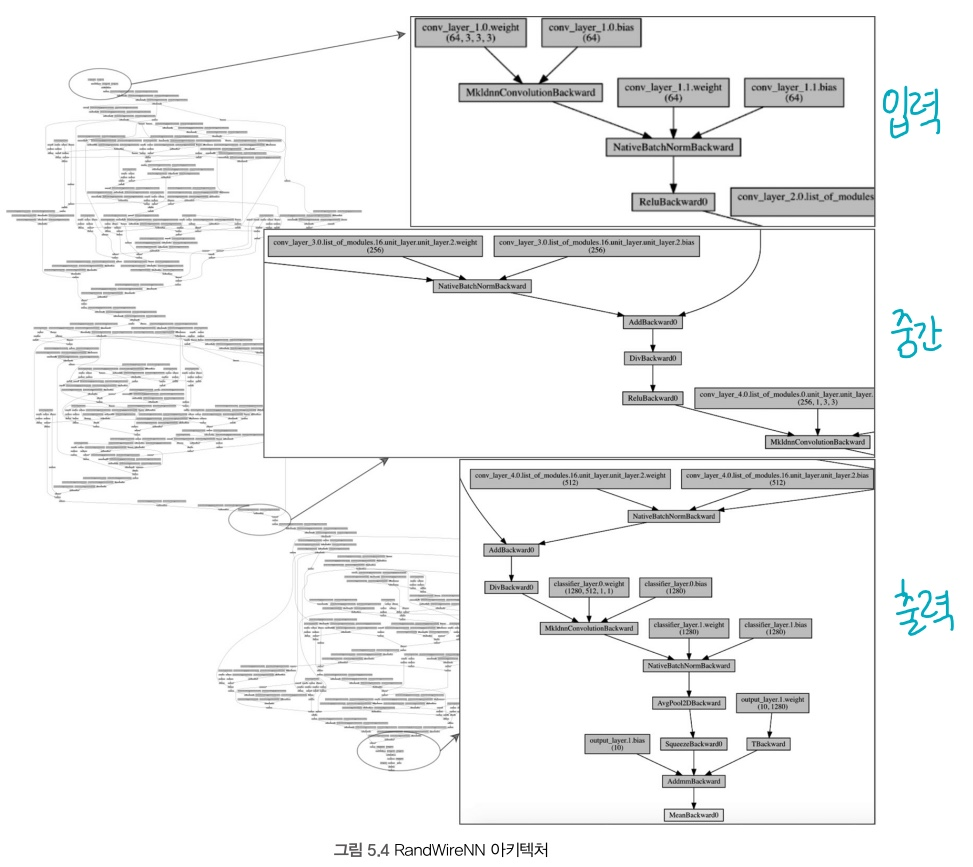

1. 시작 부분
- 64 채널 3x3 2차원 합성곱 계층, 64채널 1x1 점별 2차원 합성곱 계층을 이어 구성

2. 중간부
- 세 번째 단계 랜덤 그래프와 네 번째 단계 랜덤 그래프 사이 바뀌는 부분을 확인할 수 있음
- 3단계 랜덤 그래프인 `conv_layer_3`의 싱크 뉴런과 뒤이어 나오는 4단계 랜덤 그래프인 `conv_layer_4`의 소스 뉴런을 확인할 수 있음

3. 출력 부분
- 최종 출력 계층, 4단계 랜덤 그래프의 싱크 뉴런(512 채널, 분리 가능한 2차원 합성곱 계층)
- 그 뒤로 완전 연결 평면화 계층이 이어지고 그 결과로 크기가 1280인 특징 벡터를 얻게 됨
- 뒤이어 완전 연결 소프트맥스 계층이 나오고 여기에서 10개 클래스의 확률이 만들어짐